# Finetuning a language model

<!--- @wandbcode{dlai_05} -->

Let's see how to finetune a language model to generate character backstories using HuggingFace Trainer with wandb integration. We'll use a tiny language model (`TinyStories-33M`) due to resource constraints, but the lessons you learn here should be applicable to large models too!

# Training & Finetuning LLMs

using weights & biases
---------

Training from scratch
1. long & expensive training runs
2. expensive & difficult evaluations
3. monitoring is critical
4. ability to restore training from a checkpoint

Fine-tuning
1. efficient methods being developed
2. expensive & difficult evaluations

In [1]:
!pip install -qqq datasets wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00


In [2]:
from transformers import AutoTokenizer
from datasets import load_dataset
from transformers import AutoModelForCausalLM
from transformers import Trainer, TrainingArguments
import transformers
transformers.set_seed(42)

import wandb

In [3]:
wandb.login(anonymous="allow")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: (1) Private W&B dashboard, no account required
wandb: (2) Use an existing W&B account


wandb: Enter your choice: 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
model_checkpoint = "roneneldan/TinyStories-33M"

### Preparing data

We'll start by loading a dataset containing Dungeons and Dragons character biographies from Huggingface.

> You can expect to get some warning here, this is ok

In [5]:
ds = load_dataset('MohamedRashad/characters_backstories')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/262 [00:00<?, ?B/s]

(…)-00000-of-00001-f131735b1a05d489.parquet:   0%|          | 0.00/2.07M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [6]:
# Let's take a look at one example
ds["train"][400]

{'text': 'Generate Backstory based on following information\nCharacter Name: Dewin \nCharacter Race: Halfling\nCharacter Class: Sorcerer bard\n\nOutput:\n',
 'target': 'Dewin thought he was a wizard, but it turned out it was the draconic blood in his veins that brought him eldritch power.  Music classes in wizarding college taught him yet another use for his power, and when he was expelled he took up adventuring'}

In [7]:
# As this dataset has no validation split, we will create one
ds = ds["train"].train_test_split(test_size=0.2, seed=42)

In [8]:
# We'll create a tokenizer from model checkpoint
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=False)

# We'll need padding to have same length sequences in a batch
tokenizer.pad_token = tokenizer.eos_token

# Define a tokenization function that first concatenates text and target
def tokenize_function(example):
    merged = example["text"] + " " + example["target"]
    batch = tokenizer(merged, padding='max_length', truncation=True, max_length=128)
    batch["labels"] = batch["input_ids"].copy()
    return batch

# Apply it on our dataset, and remove the text columns
tokenized_datasets = ds.map(tokenize_function, remove_columns=["text", "target"])

tokenizer_config.json:   0%|          | 0.00/722 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1857 [00:00<?, ? examples/s]

Map:   0%|          | 0/465 [00:00<?, ? examples/s]

In [9]:
# Let's check out one prepared example
print(tokenizer.decode(tokenized_datasets["train"][900]['input_ids']))

Generate Backstory based on following information
Character Name: Mr. Gale
Character Race: Half-orc
Character Class: Cleric

Output:
 Growing up the only half-orc in a small rural town was rough. His mother didn't survive childbirth and so was raised in a church in a high mountain pass, his attention was always drawn by airships passing through, and dreams of an escape. Leaving to strike out on his own as early as he could he made a living for most of his life as an airship sailor, and occasionally a pirate. A single storm visits him throughout his life, marking every major


### Training
Let's finetune a pretrained language model on our dataset using HF Transformers and their wandb integration.

In [10]:
# We will train a causal (autoregressive) language model from a pretrained checkpoint
model = AutoModelForCausalLM.from_pretrained(model_checkpoint);

config.json:   0%|          | 0.00/968 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/291M [00:00<?, ?B/s]

In [11]:
# Start a new wandb run
run = wandb.init(project='dlai_lm_tuning', job_type="training", anonymous="allow")

wandb: Currently logged in as: alicechen005 (alicechen005-new-york-university). Use `wandb login --relogin` to force relogin


In [12]:
# Define training arguments
model_name = model_checkpoint.split("/")[-1]
training_args = TrainingArguments(
    f"{model_name}-finetuned-characters-backstories",
    report_to="wandb", # we need one line to track experiments in wandb
    num_train_epochs=1,
    logging_steps=1,
    evaluation_strategy = "epoch",
    learning_rate=1e-4,
    weight_decay=0.01,
    no_cuda=True, # force cpu use, will be renamed `use_cpu`
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1540: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [13]:
# We'll use HF Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
)

In [14]:
# Let's train!
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss
1,4.597100,3.353577


TrainOutput(global_step=233, training_loss=3.721863816224454, metrics={'train_runtime': 343.9587, 'train_samples_per_second': 5.399, 'train_steps_per_second': 0.677, 'total_flos': 40423258718208.0, 'train_loss': 3.721863816224454, 'epoch': 1.0})

In [15]:
transformers.logging.set_verbosity_error() # suppress tokenizer warnings

prefix = "Generate Backstory based on following information Character Name: "

prompts = [
    "Frogger Character Race: Aarakocra Character Class: Ranger Output: ",
    "Smarty Character Race: Aasimar Character Class: Cleric Output: ",
    "Volcano Character Race: Android Character Class: Paladin Output: ",
]

table = wandb.Table(columns=["prompt", "generation"])

for prompt in prompts:
    input_ids = tokenizer.encode(prefix + prompt, return_tensors="pt")
    output = model.generate(input_ids, do_sample=True, max_new_tokens=50, top_p=0.3)
    output_text = tokenizer.decode(output[0], skip_special_tokens=True)
    table.add_data(prefix + prompt, output_text)

wandb.log({'tiny_generations': table})

**Note**: LLM's don't always generate the same results. Your generated characters and backstories may differ from the video.

In [16]:
wandb.finish()

eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
train/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇█████
train/grad_norm,█▄▄▄▃▂▂▂▄▂▂▂▃▂▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▁▂▁▂▁▂
train/learning_rate,█████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▇▅▆▄▄▂▂▄▅▅▄▃▄▄▂▃▄▃▅▃▂▄▄▃▁▃▃▄▃▃▃▂▂▂▂▃▂▂▃
eval/loss,3.35358
eval/runtime,20.7809


Saving train_loss.png to train_loss.png


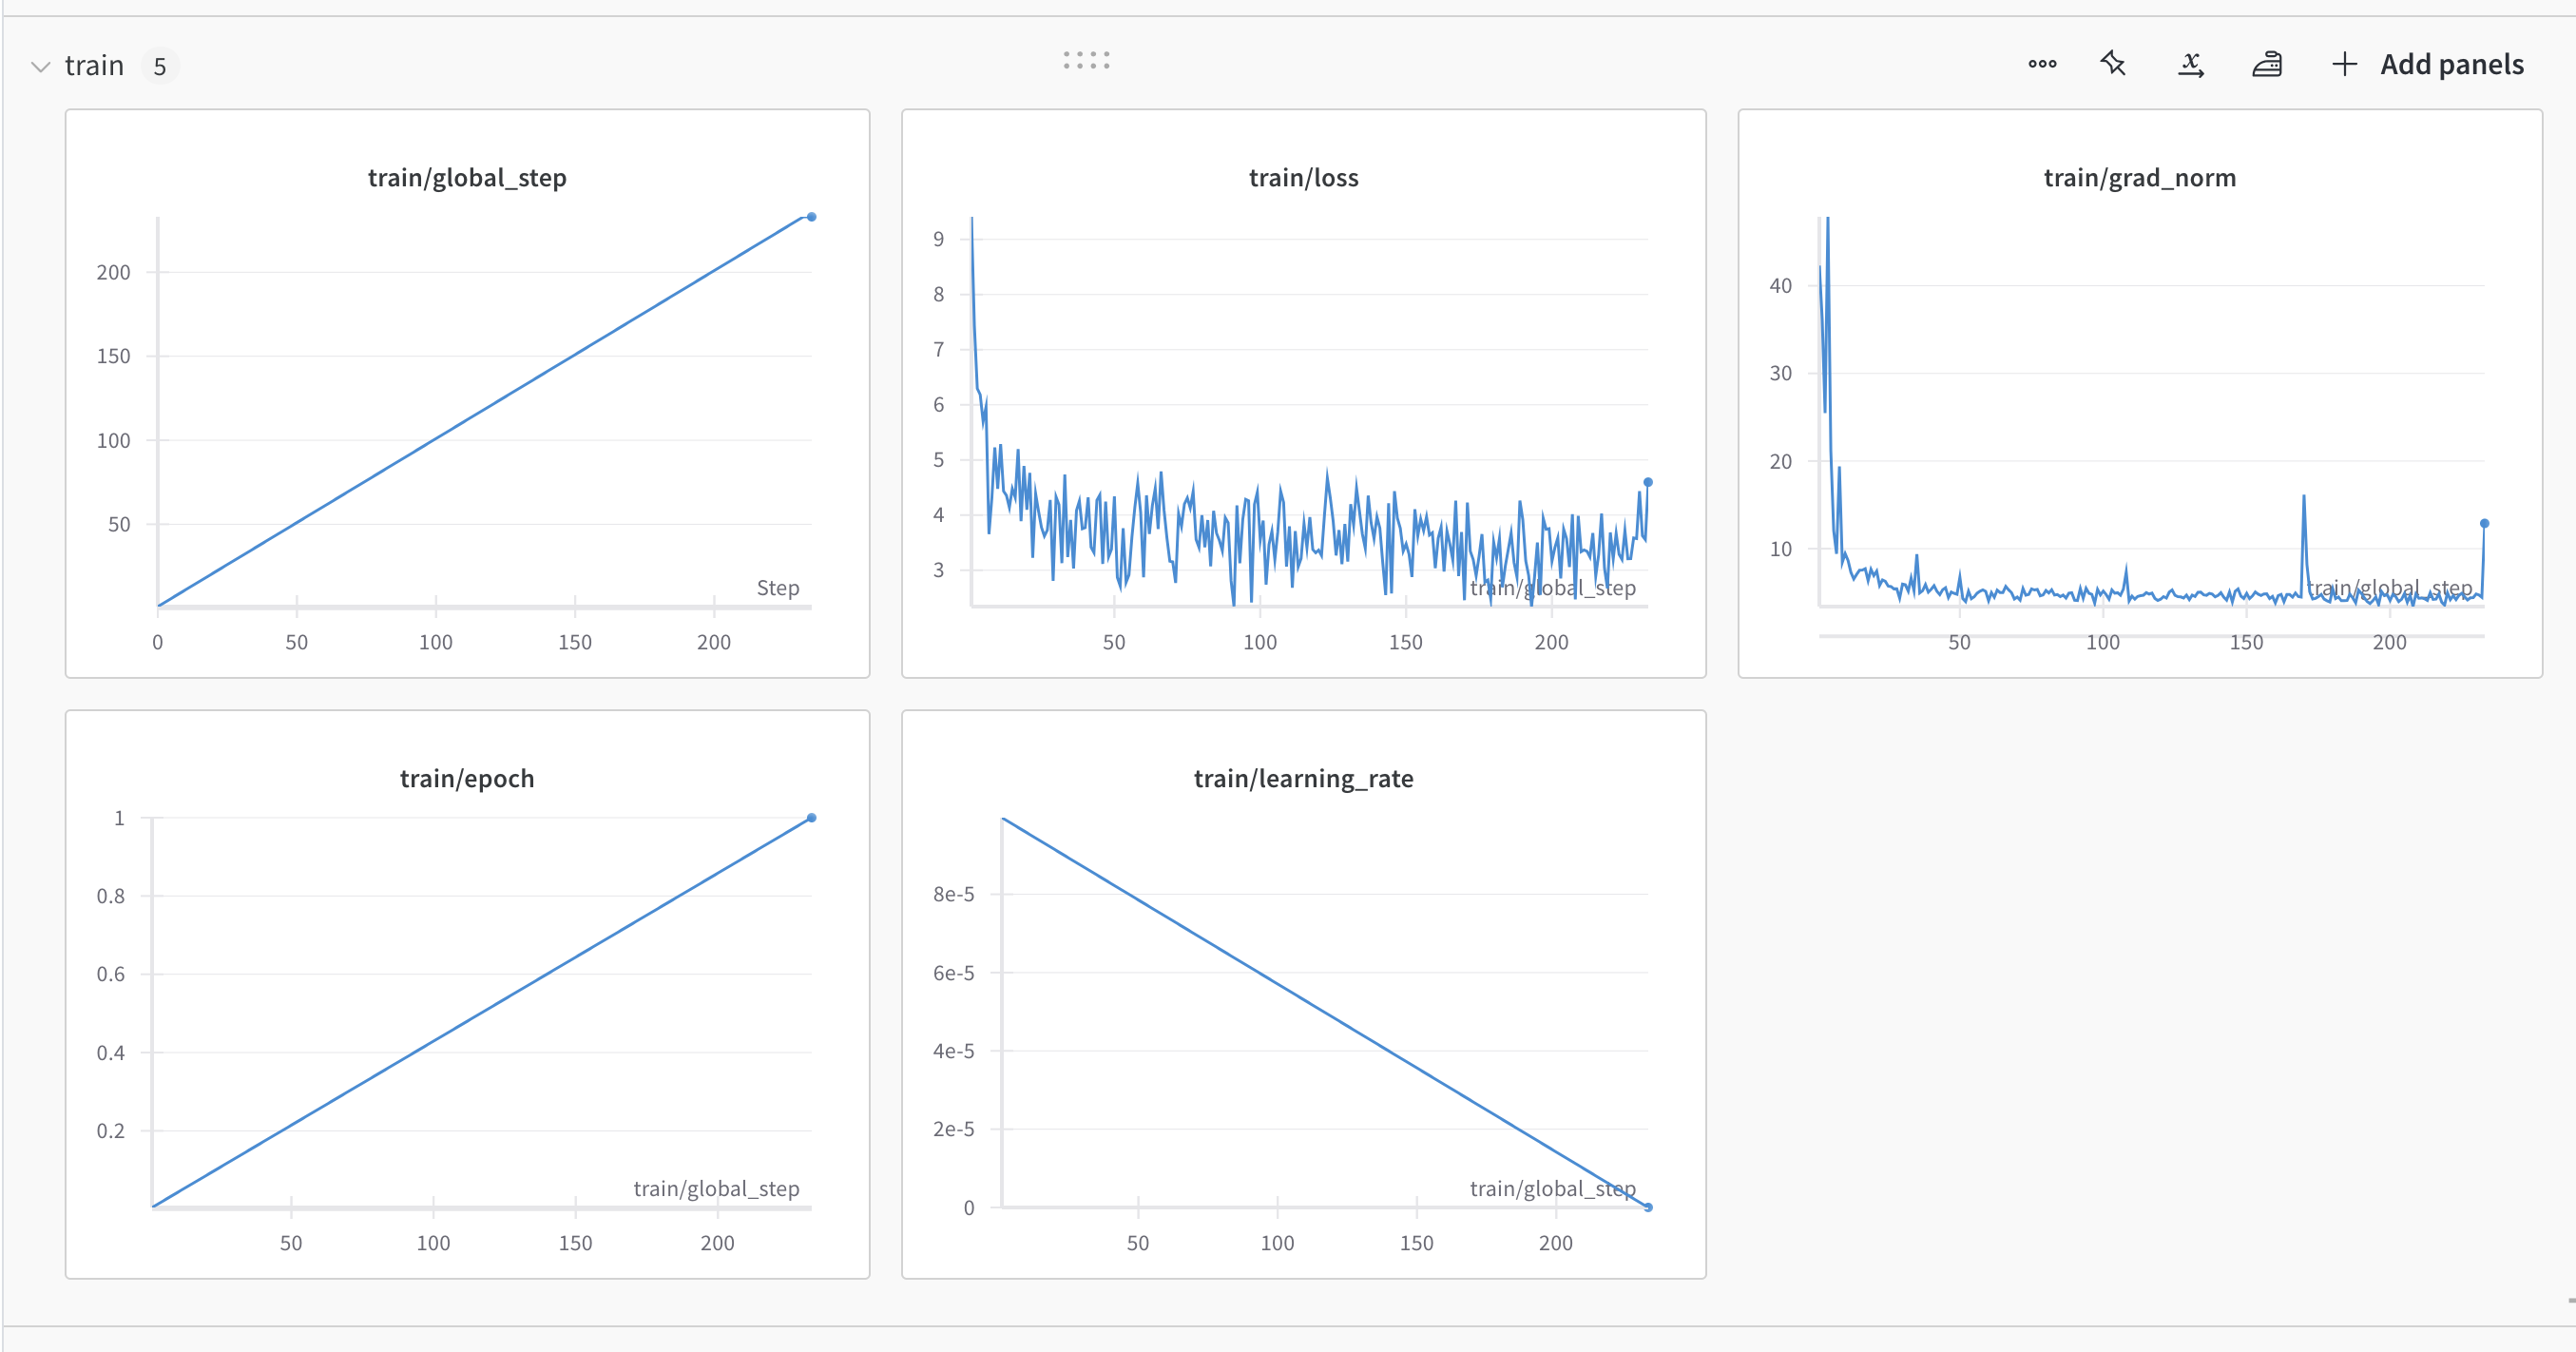

In [18]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='train_loss.png')

Saving dashboard2.png to dashboard2.png


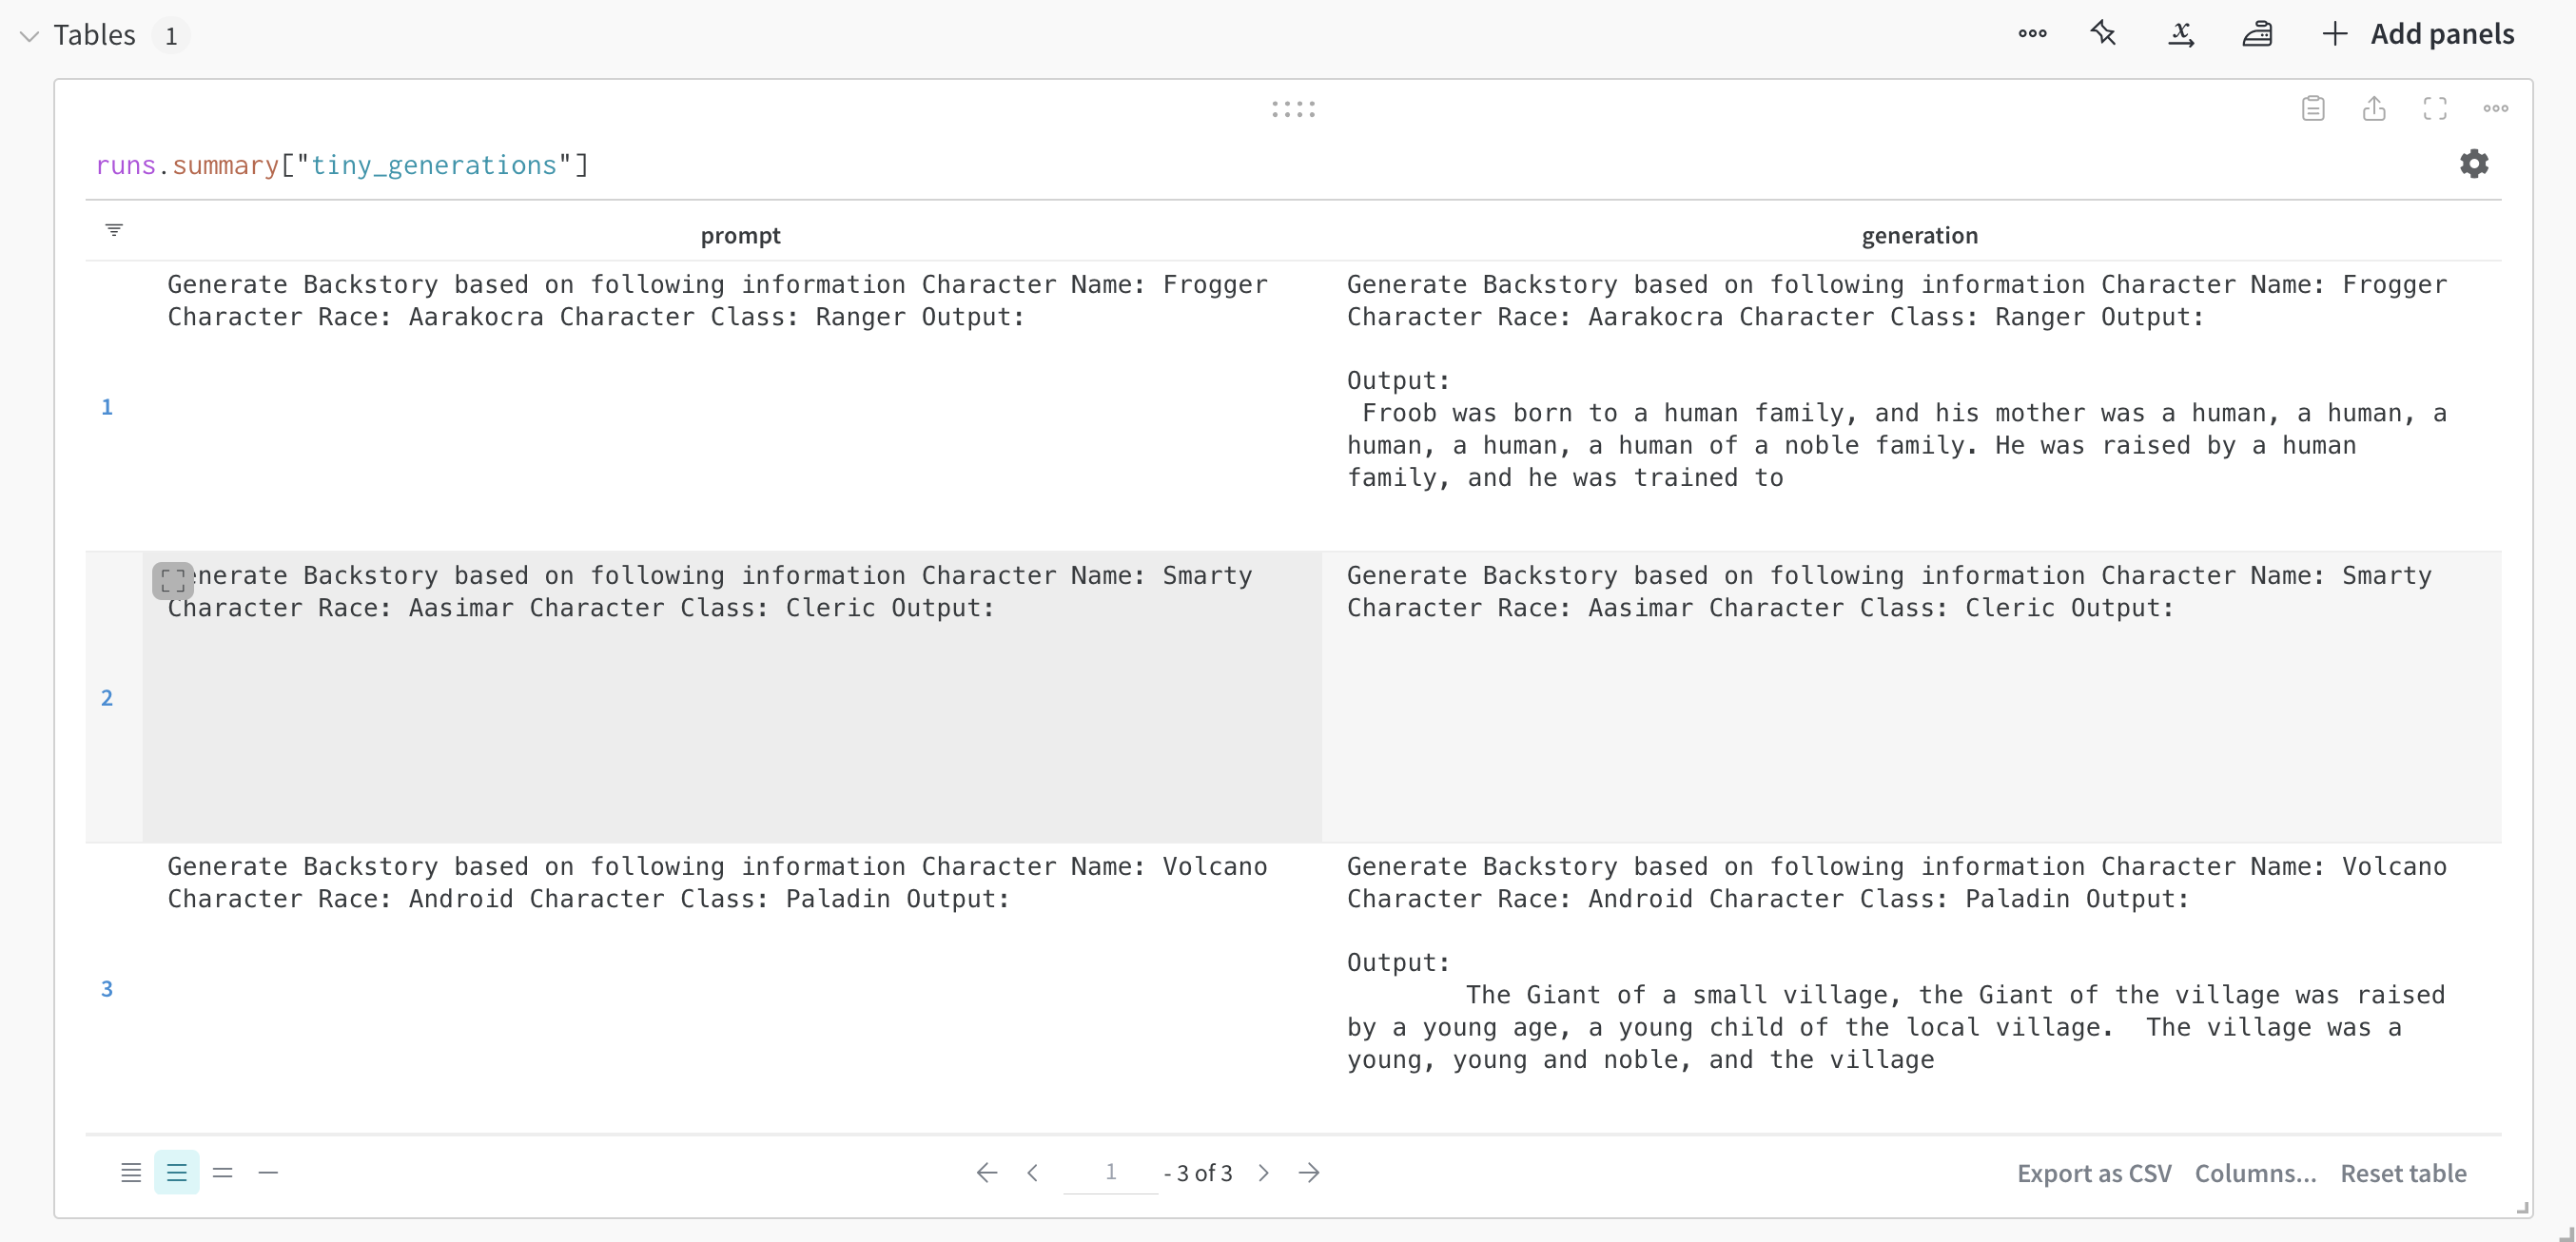

In [20]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='dashboard2.png')

Saving dashboard.png to dashboard.png


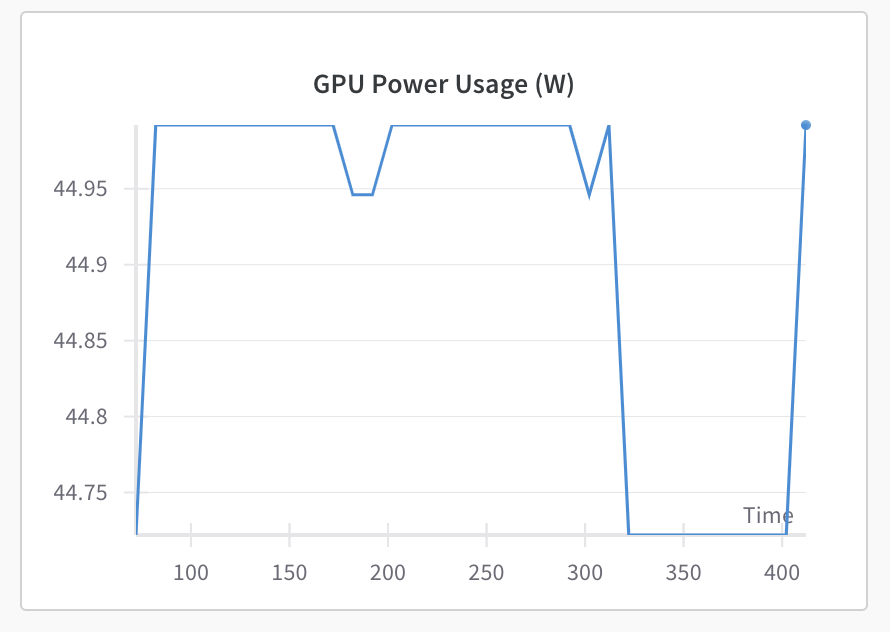

In [19]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='dashboard.png')